# Hierarchical Navigable Small Worlds - HNSW
* [Hierarchical Navigable Small Worlds - HNSW](https://zilliz.com/blog/hierarchical-navigable-small-worlds-HNSW)
* [Vector Search](https://github.com/fzliu/vector-search/)
* [Reference code](https://github.com/fzliu/vector-search/blob/main/indexes/hnsw.py)
* [Reference notebook](https://github.com/fzliu/vector-search/blob/main/tutorials/2023-03-02_data_science_dojo_00_ann_algorithms.ipynb)

## Code from tutorial using random data

In [67]:
import numpy as np
import pandas as pd

from bisect import insort
from collections import namedtuple
from heapq import heapify, heappop, heappush
from sklearn.metrics.pairwise import cosine_similarity

Vertex = namedtuple('Vertex', 'vec neighbors layer')


class HNSW:

    def __init__(self, layers=5, multi_factor=0.62, efc=20):
        self._layers = layers
        self._multi_factor = multi_factor
        self._efc = efc
        self._index = [[] for _ in range(layers)]

    def create(self, dataset):
        self._dataset = dataset
        for vec in dataset:
            self.insert(vec)
    
    def search(self, query, ef=1):
        index = self._index
        if not index[0]:
            return []
    
        best_v = 0 # set the initial best vertex to the entry point
        for graph in index:
            best_d, best_v = self._search_layer(graph, best_v, query, ef=1)[0]
            if graph[best_v][2]:
                best_v = graph[best_v][2]
            else:
                return self._search_layer(graph, best_v, query, ef=ef)
    
    def _search_layer(self, graph, entry, query, ef=1):
        best = (np.linalg.norm(graph[entry][0] - query), entry)
        nearest_neighbors = [best]
        visited = set(best)
        candidates = [best]
        heapify(candidates)
    
        # find top-k nearest neighbors
        while candidates:
            candidate = heappop(candidates)
            if nearest_neighbors[-1][0] < candidate[0]:
                break
    
            # loop through all nearest neighbors to the candidate vector
            for neighbor_entry in graph[candidate[1]][1]:
                distance = np.linalg.norm(graph[neighbor_entry][0] - query)
                if (distance, neighbor_entry) not in visited:
                    visited.add((distance, neighbor_entry))
    
                    # push only "better" vectors into candidate heap
                    if distance < nearest_neighbors[-1][0] or len(nearest_neighbors) < ef:
                        heappush(candidates, (distance, neighbor_entry))
                        insort(nearest_neighbors, (distance, neighbor_entry))
                        if len(nearest_neighbors) > ef:
                            nearest_neighbors.pop()
    
        return nearest_neighbors
        
    def _get_insert_layer(self):
        layers = self._layers
        multi_factor = self._multi_factor
        # multi_factor is used to normalize the distribution
        which_layer = -int(np.log(np.random.random()) * multi_factor)
        return min(which_layer, layers)

    def insert(self, vec: np.ndarray, efc=10):
        # if the index is empty, insert the vector into all layers and return
        index = self._index
        layers = self._layers
        if not index[0]:
            i = None
            for graph in index[::-1]:
                graph.append(Vertex(vec, [], i))
                i = 0
            return
    
        layer = self._get_insert_layer()
        
        start_v = 0
        for n, graph in enumerate(index):
            # perform insertion for layers [layer, layers) only
            if n < layer:
                _, start_v = self._search_layer(graph, start_v, vec, ef=1)[0]
            else:
                some_layer = len(index[n+1]) if n < layers-1 else None
                node = Vertex(vec, [], some_layer)
                nearest_neighbors = self._search_layer(graph, start_v, vec, ef=efc)
                for nearest_neighbor in nearest_neighbors:
                    node.neighbors.append(nearest_neighbor[1]) # outbound connections to NNs
                    graph[nearest_neighbor[1]][1].append(len(graph)) # inbound connections to node
                graph.append(node)
            # set the starting vertex to the nearest neighbor in the next layer
            start_v = graph[start_v][2]

    def plot_similar(self, df: pd.DataFrame, query_index: int, ef=5):
        """
        Helper function to take a dataframe index as input query 
        and display the k nearest neighbors
        """

        distances = []
        nearest_indices = []
        for (dist, idx) in self.search(self._dataset[query_index], ef=ef):
            distances.append(dist)
            nearest_indices.append(idx)
    
        # Plot input image
        with Image.open(df["img_path"][query_index]) as img:
            img = img.convert("RGB")
            plt.imshow(img)
        plt.title(f"Query Product: {query_index}")
    
        # Plot nearest neighbors images
        fig = plt.figure(figsize=(20, 4))
        plt.suptitle("Similar Products")
        for idx, neighbor in enumerate(nearest_indices):
            plt.subplot(1, len(nearest_indices), idx+1)
            with Image.open(df["img_path"][neighbor]) as img:
                img = img.convert("RGB")
                plt.imshow(img)
                plt.title(f"Distance: {distances[idx]:.3f}")
        plt.tight_layout()

In [68]:
import queue
import numpy as np

class FlatIndex:

    def __init__(self):
        self._index = None

    def create(self, dataset):
        """The index is the same as the dataset itself."""
        self._index = dataset

    def search(self, vector, nq=10):
        """Naive (flat) search."""
        nns = queue.PriorityQueue()  # should probably use heapq
        for (n, v) in enumerate(self._index):
            d = -np.linalg.norm(v - vector)
            if nns.qsize() == 0 or d > nns.queue[0][0]:
                nns.put((d, n))
                if nns.qsize() > nq:
                    nns.get()
        out = []
        for n in range(nq):
            if nns.empty():
                break
            out.insert(0, nns.get())
        return out

    @property
    def index(self):
        if self._index:
            return self._index
        raise ValueError("Call create() first")

In [69]:
dataset = np.random.normal(size=(1000, 128))

hnsw = HNSW()
hnsw.create(dataset)
%timeit hnsw.search(np.random.randn(128))

1.58 ms ± 59.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [70]:
value = np.random.randn(128)
hnsw.search(value, ef=5)

[(13.644086224087339, 61),
 (13.853199759287742, 159),
 (13.905184974757887, 302),
 (13.947281153806967, 834),
 (14.050075035155674, 1)]

In [71]:
flat = FlatIndex()
flat.create(dataset)
flat.search(value, nq=5)

[(-13.508137006711879, 890),
 (-13.644086224087339, 61),
 (-13.684905805689379, 519),
 (-13.756867912562619, 588),
 (-13.853199759287742, 159)]

## Code using embeddings with CLIP and FAISS

In [55]:
import os
import sys
import shutil
import faiss
import pandas as pd
import numpy as np 
import plotly.express as px

from PIL import Image
from random import randint
from tqdm import tqdm
from matplotlib import pyplot as plt

tqdm.pandas()

if os.path.exists("image_df.pkl"):
    image_df = pd.read_pickle("image_df.pkl")
else:
    print("RUN THE TUTORIAL 1_similarity_search.ipynb")

In [56]:
image_df.head()

,img_path,embedding,simclr_embeddings,clip_image_embedding
0,../data/cv/fashion/1000000151.jpg,"[0.0, 0.13571438, 0.07747779, 0.0, 0.06867723,...","[0.0, 0.0, 0.0, 0.016052447259426117, 0.067167...","[-0.08758709579706192, -0.3124939203262329, 0...."
1,../data/cv/fashion/1000000170.jpg,"[0.020778598, 0.09365222, 0.10665407, 0.051480...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.03924274817109108, -0.040139153599739075, ..."
2,../data/cv/fashion/1000001050.jpg,"[0.0, 0.017002566, 0.0101805935, 0.00038356014...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.07215095311403275, -0.07616670429706573, 0..."
3,../data/cv/fashion/1000001113.jpg,"[0.0, 0.032862574, 0.0, 0.0, 0.16102254, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.10626209527254105, 0.0,...","[0.12239596992731094, 0.23508524894714355, 0.2..."
4,../data/cv/fashion/1000001117.jpg,"[0.07896162, 0.0087613, 0.06798893, 0.0, 0.055...","[0.0, 0.0, 0.0, 0.0, 0.014906682074069977, 0.0...","[0.24037981033325195, 0.0034865587949752808, 0..."


In [57]:
embeddings = image_df["clip_image_embedding"]
embeddings = embeddings.to_numpy()
embeddings = np.array([np.array(embedding) for embedding in embeddings])
embeddings.shape

(6239, 512)

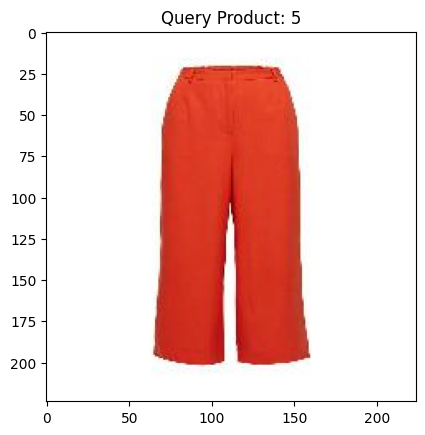

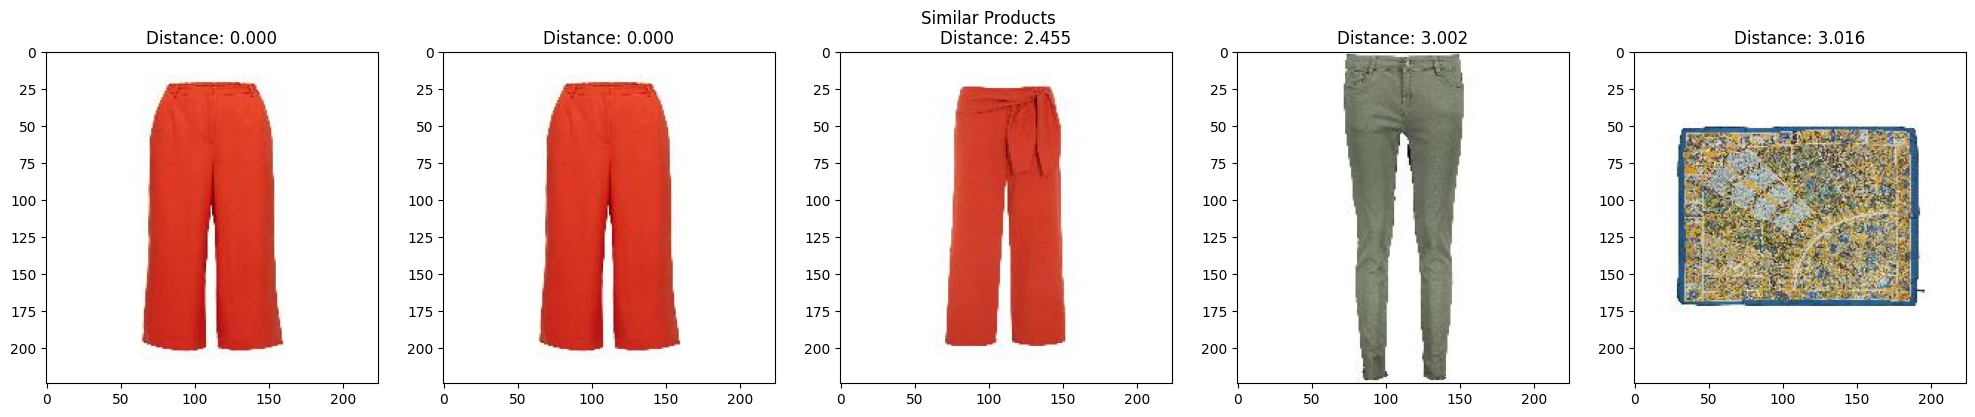

In [72]:
hnsw_embedding = HNSW()
hnsw_embedding.create(embeddings)
hnsw_embedding.plot_similar(df=image_df, query_index=5)

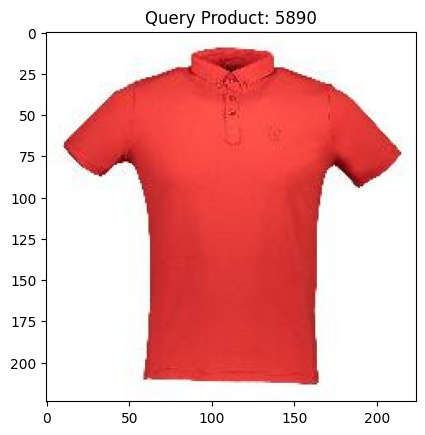

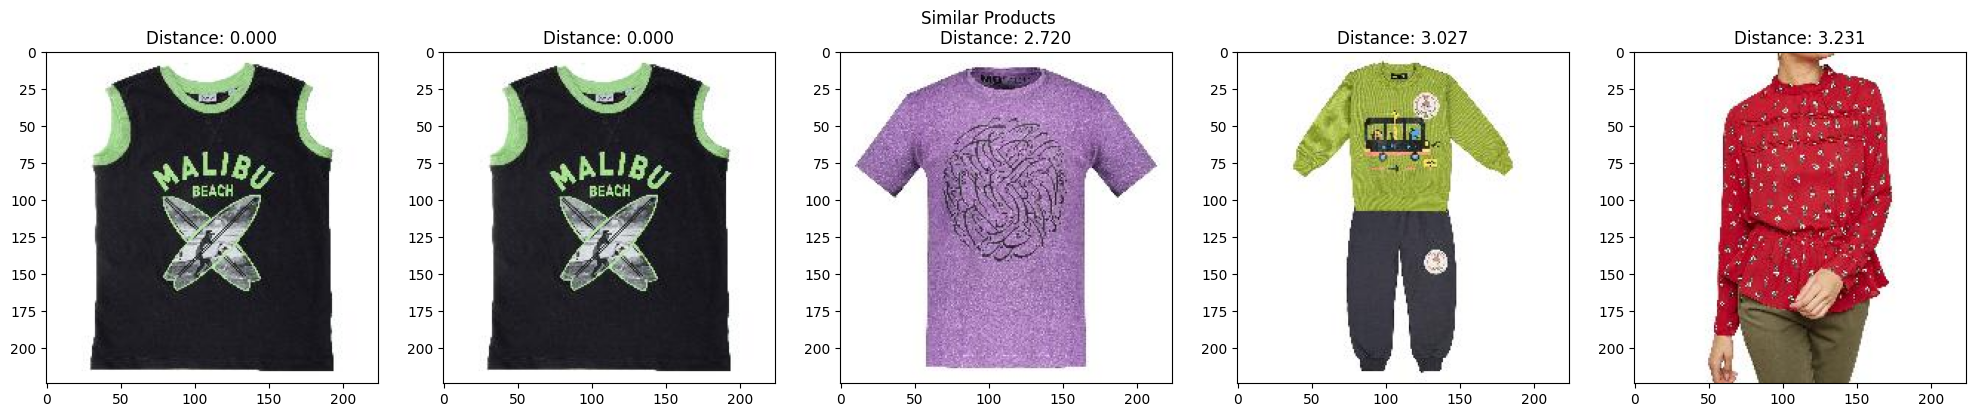

In [73]:
hnsw_embedding.plot_similar(df=image_df, query_index=5890)

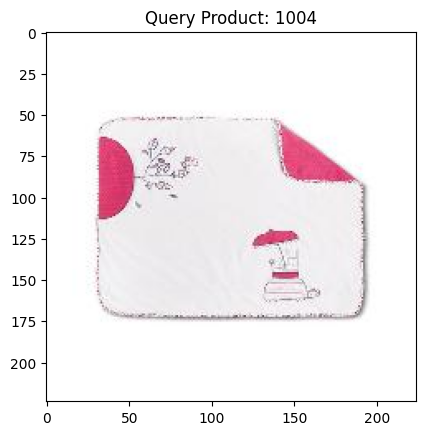

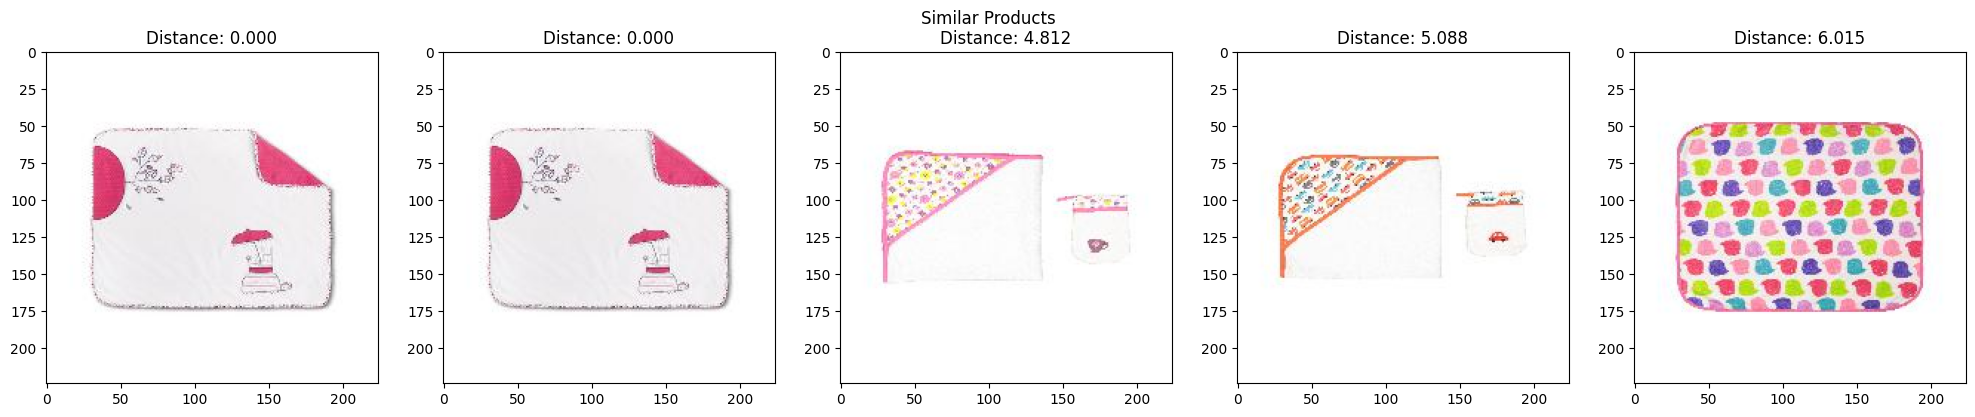

In [77]:
hnsw_embedding.plot_similar(df=image_df, query_index=randint(0, len(embeddings)))

In [63]:
dims = embeddings.shape[1]
number_links_per_vertex = 32
index = faiss.IndexHNSWFlat(dims, number_links_per_vertex)
print("max level:", index.hnsw.max_level)
levels = faiss.vector_to_array(index.hnsw.levels)
np.bincount(levels)

max level: -1


array([], dtype=int64)

In [64]:
index.add(embeddings)

In [66]:
levels = faiss.vector_to_array(index.hnsw.levels)
print("max level:", index.hnsw.max_level)
np.bincount(levels)

max level: 2


array([   0, 6065,  169,    5], dtype=int64)

In [ ]:
def plot_similar(df: pd.DataFrame, query_index: int, k=5):
    """
    Helper function to take a dataframe index as input query 
    and display the k nearest neighbors
    """

    distances = []
    nearest_indices = []
    for (dist, idx) in index.search(query_index, k=k):
        distances.append(dist)
        nearest_indices.append(idx)

    # Plot input image
    with Image.open(df["img_path"][query_index]) as img:
        img = img.convert("RGB")
        plt.imshow(img)
    plt.title(f"Query Product: {query_index}")

    # Plot nearest neighbors images
    fig = plt.figure(figsize=(20, 4))
    plt.suptitle("Similar Products")
    for idx, neighbor in enumerate(nearest_indices):
        plt.subplot(1, len(nearest_indices), idx+1)
        with Image.open(df["img_path"][neighbor]) as img:
            img = img.convert("RGB")
            plt.imshow(img)
            plt.title(f"Distance: {distances[idx]:.3f}")
    plt.tight_layout()